# DEMO: Manifold Learning

## Introducción

Hemos visto como PCA (análisis de componentes principales) puede encarar tareas de reducción de la dimensionalidad básicamente disminuyendo el número de features en un dataset manteniendo las relaciones "esenciales" entre los datos. Si bien PCA es flexible y altamente interpretable no funciona demasiado bien si las relaciones entre los datos exhiben fuertes rasgos de no linealidad.

Para encarar este tipo de problemas existen otros métodos llamados "Manifold Learning". Son una clase de estimadores no supervisados que buscan describir un dataset como un geometría de baja dimensionadlidad "embebida" en un espacio multidimensional. Podría pensarse en una analogía con una hoja de papel: en realidad, es espacio de dos dimensiones, pero que puede ser rotado, doblado, etc. sobre esas dos dimensiones en un espacio tridimensional.

Ahora bien: rotar o estirar la hoja no altera la geometría "plana" del papel. Se trata de transformaciones lineales. En cambio, doblarla, hacerla un tirabuzón, abollarla son trasnformaciones no lineales de una geometría bidimensional en un espacio tridimensional.

Los algoritmos basados en Manifold Learning van a tratar de aprender la naturaleza fundamentalmente bidimensional del papel aún si está realizada en un espacio tridimensional.

Vamos a ver tres técnicas de Manifold Learning:

- Multimensional Scalling (MDS)
- Locally Linear Embedding (LLE)
- Isometric Mapping (IsoMap)

Primero, importemos los paquetes

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Manifold Learning: ejemplo "HELLO"

Para tratar de hacer estos conceptos un poco más claros, vamos a generar datos bi-dimensionales que nos sirvan para definir un "manifold". Acá hay una función que va a crear datos con la forma de la palabra "HELLO".

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'DATOS', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

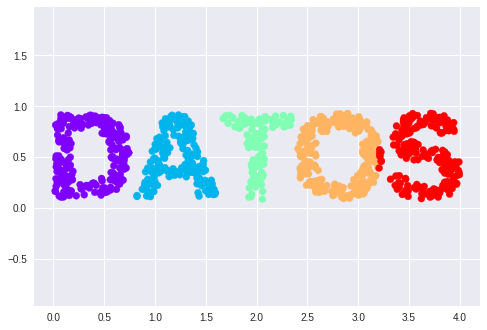

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## Multimensional Scalling (MDS)

Observando  los datos podemos ver que la relación entre X e Y no parece ser la mejor descripción de los datos. Podemos reescalarlos, achicarlos, rortarles y el "DATOS" sigue siendo evidente.

Por ejemplo, rotemos la matriz y veremos que los valores de X e Y cambian pero la relación se mantiene inalterada.

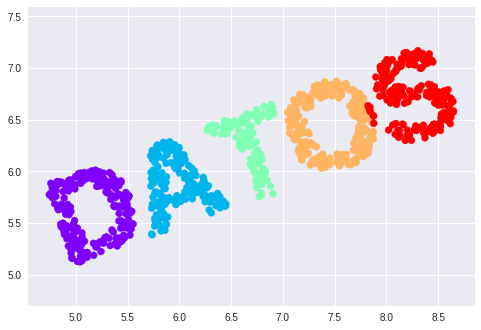

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

Es interesante observar entonces que los valores $X$ e $Y$ no son fundamentales para extraer la información y las relaciones en los datos. En este caso, la distancia entre los diferentes puntos es la información fundamental: es decir, la distancia de cada punto contra el resto de los puntos del dataset. 

Una manera común de representar esto (ya lo vimos) es una matriz de distancias: para $N$ puntos, generamos un array de $N x N$ tal que cada entrada $(i,j)$ contiene la distancia entre cada punto $i$ y $j$.

Vamos a usar `sklearn` para calcular de forma eficiente las distancias en base a nuestros datos originales.

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

Como se puede ver, lo que obtuvimos es una matriz de 1000 x 1000. Una buena representación gráfica de la matriz es la siguiente:

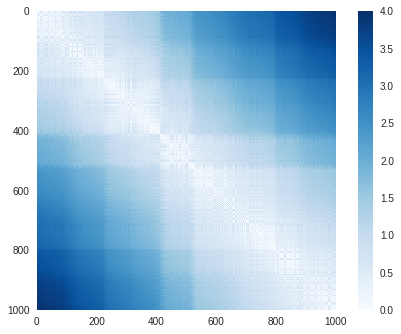

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

Si ahora generamos una matriz similar en base a nuestros datos rotados. 

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

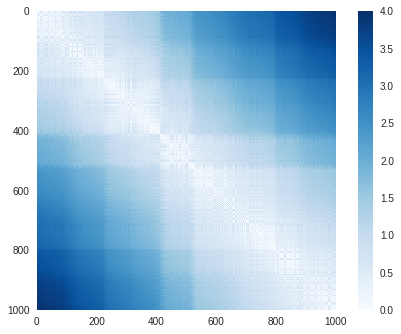

In [8]:
plt.imshow(D2,zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar()

La matriz de distancias nos da una representación de los datos que es invariante a las rotaciones y traslaciones. Ahora bien, la visualización de la matriz de distancias no es totalmente intuitiva: hemos perdido todo signo visible de la estructura de los datos: el "DATOS" que veíamos antes.

Computar la matriz de distancias de las coordenadas $(x,y)$ es bastante directo (simplemente, aplicamos alguna función de distancia a los dos puntos). El proceso inverso (pasar de la matriz de distancias a las coordenadas no es tan simple. Este último proceso es el que el algoritmo de MDS va a hacer: recupera una representación D-dimensional de los datos a partir de una matriz de distancias. Veamos como funciona para nuestra matriz de distancia:

(-2.0598671472896992,
 1.92075816850354,
 -1.6045378774577066,
 1.5310376650239204)

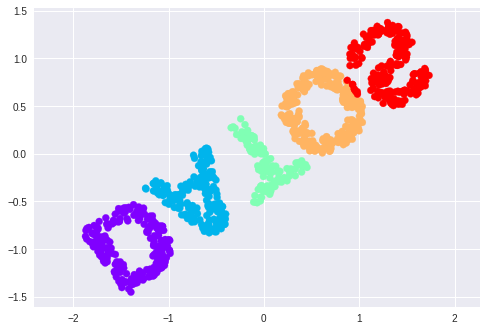

In [9]:
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal')

El algoritmo de MDS recupera una de las posibles representaciones en coordenadas bidimensionales de nuestros datos utilizando solamente la matriz de distancias $NxN$ que describe la relación entre los datapoints.

## MDS como método de Manifold Learning

La utilidad de este algoritmo se hace más evidente al considerar el hecho de que las matrices de distancias pueden ser computadas de datos con cualquier nivel de dimensionalidad. Por ejemplo, simplemente rotando los datos en el plano-bidimensional podemos proyectarlos en tres dimensiones usando la siguiente función (que es básicamente una generalización de la rotación de matrices usada previamente):

In [10]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

Viualizacemos el resultados;

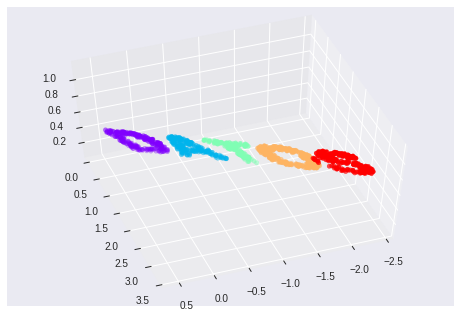

In [11]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=56)

Podemos ahora llamar al estimador MDS que utilizando como input esta estructura de datos tridmensional va a computar la matriz de distancias y luego determinar cuál es la representación geométrica en baja dimensionalidad (en este caso, dos dimensiones) para esta matriz. El resultado recupera la representación original de los datos:

(-2.0598671472896974,
 1.9207581685035375,
 -1.604537877457705,
 1.5310376650239219)

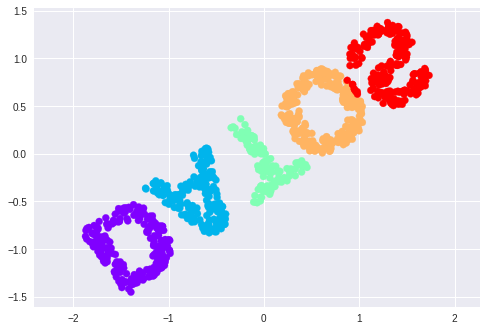

In [12]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal')

Este es el objetivo esencial de un estimador de manifold learning: dado un set de datos en un espacio multimensional busca una representación de menor dimensionalidad que preserve ciertas relaciones dentro de los datos. En el caso de MDS la cantidad que se busca preservar es la distancia entre todos los pares de puntos.

## Embeddings no lineales: cuando el MDS falla

Hasta ahora hemos discutidos situaciones donde los "embeddings" son lineales: rotaciones, traslaciones y reescalamientos de los datos. Cuando estos "embeddings" son no lineales MDS comienza a funcionar mal. No alcanza con rotar o trasladar los datos para recuperar la estructura subyacente.

Veamos el siguiente caso que toma el mismo input de datos y lo "dobla" en forma de S en un espacio tridimensional.

In [13]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

Una vez más, estamos en un espacio tridimensional pero la forma es mucho más rebuscada.

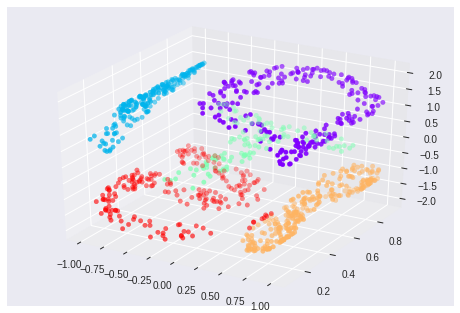

In [14]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

La relación fundamental entre los datapoints todavía se puede recuperar pero en este caso los datos han sido transformados en una forma no lineal: fueron "envueltos" en la forma de una "S".

Si tratamos un simmple algoritmo de MDS en estos datos, el mismo no va a poder recuerar ("desenvolver") este "embedding" no lineal y se pierden las relaciones fundamentales en los datos.

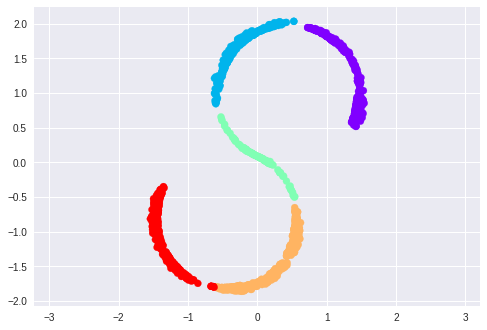

In [15]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

La mejor represetnación bidimensional de los datos no logra captar la estructura central de los datos y lo que observamos es la forma de "S".

## Manifolds no lineales: Locally Linear Embeddings

La fuente del problema es que MDS trata de preservar las distancias entre todos los puntos del embedding... incluso aquellos que están muy lejos entre sí. 

¿Pero qué pasaría si modificamos este algoritmo para que solamente preserve las distancias de los puntos cercanos entre sí. El resultado va a ser un poco más cercano a los que estamos pensando.

Una intuición de estos dos enfoques puede verse en la siguiente figura:

<img src="../Extras/LLE-vs-MDS.png">

Cada línea representa la distancia que va a ser preservada en el embedding. A la izquierda hay una representación del modelo usando MDS: trata de preservar las distancias entre todos los pares de puntos. A la derecha aparece la representación del modelo utilizando un algoritmo de manifold learning llamado Locally Linear Embedding (LLE): en lugar de preservar todas las distancias, trata de preservar solamente aquellas que aparecen entre vecinos cercanos. En este caso, se usaron 100 vecinos cercanos.

Al observar el panel de la izquierda puede notarse por qué MDS falla: no hay manera de "aplanar" estos datos de forma adecuada preservando la longitud de cada línea de distancia entre dos puntos. En cambio, en el de la izquierda parece un poco más fácil. Podemos imaginar "desenrrolar" los datos de forma tal que se mantengan las longitudes de las líneas. Esto es lo que logra realizar LLE.

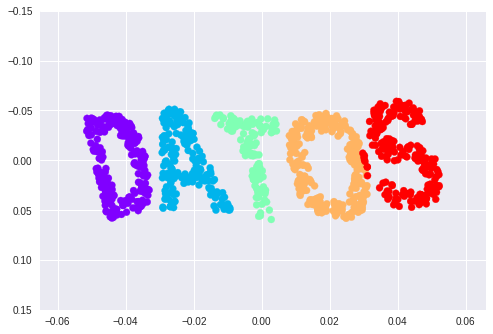

In [16]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=90, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

Si bien aparece con un cierto grado de distorsión (comparado al original) parece capturar las relaciones fundamentales en los datos.

## Manifolds no lineales: IsoMaps

Por último, vamos a presentar un último método de reducción de la dimensionalidad no lineal: IsoMapas. Los Isomapas también intentan reconstruir una representación en baja dimensionalidad a partir de una matriz de distancias. 

Tiene diferencias tanto con MDS como con LLE. 
    
   - A diferencia de LLE utiliza un enfoque global (y no local) de las distancias: computa todas las distancias
   - La diferencia con MDS es que no computa las distancias rectas o euclidianas sino las _distancias geodésicas_.
   
¿Qué es una distancia geodésica? Básicamente, es la distancia "no recta" entre dos puntos en un espacio "curvo".

Imaginemos que quiero encontrar la distancia entre dos puntos en el siguiente espacio tridimensional...

<img src="../Extras/isomap.jpg">
**Fuente:** Tenembaum J., de Silva, V. y Langford, J.(2000), "A Global Framwork for Nonlinear Dimensionality Reduction", _Science_, Vol. 290, december 2000.

En la figura A, la línea azul punteada es la distancia euclidiana. Pero si vemos con detalle lo que se observa que esa distancia no representa la estructura de relaciones entre los puntos. En cambio, la línea azul sólida es la distancia "geodésica". IsoMap trabaja con matrices de distancias geodésicas.

Ahora bien, realiza una estimación de la matriz de distancias geodésicas entre todos los puntos del dataset que puede resumirse en los siguientes pasos:

   1. Define los vecinos cercanos a cada punto (puede hacerlo mediante diferentes métodos)
   2. Construye un grafo conectando a los vecinos más cercanos
   3. Busca la distancia más cercana entre los nodos (puntos) - esta es la aproximación a la distancia geodésica-
   4. Sobre esa matriz, realiza MDS

En la figura B, vemos el "camino" encontrado por IsoMap como la aproximación a la distancia geodésica entre los dos puntos. En la figura C, vemos el embedding "desenrrolado" y las distancias estimadas.

En general, debido a este método de estimación si existen discontinuidades muy grandes en los datos IsoMap puede fallar.

Veamos, ahora, cómo funciona IsoMap en nuestro dataset.

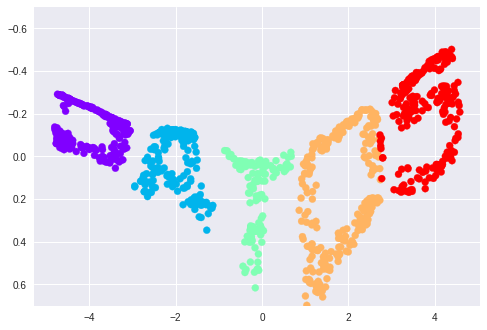

In [17]:
from sklearn.manifold import Isomap
model = Isomap(n_neighbors=90, n_components=2, eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.7, -.7);

Como podemos ver, si bien la performance es peor que en LLE, parece recuperar algunos aspectos importantes de la relación entre los datos.

## Algunas reflexiones sobre Manifold Learning

Si bien estos métodos suelen tener bastante potencia, en la práctica no suelen usarse para mucho más que lograr una visualización cualitativa relativamente simple de datos de alta dimensionalidad.

Existen algunos desafíos y desventajas que los métodos de manifold learning tienen (y que ponen a estos métodos en desventaja en relación a PCA):

* A diferencia de PCA, no hay una buena forma de manejar datos perdidos. 
* La presencia de ruido en los datos puede alterar drásticamente los embeddings. PCA, por contraste, "filtra" los ruidos a través de los componentes principales.
* En general, el embedding resultante resulta altamente dependiente del número de vecinos elegidos y no suele haber métodos "sólidos" para hacer tunning de este parámetro. En contraste, PCA no involucra este tipo de decisión.
* El óptimo global en cantidad de dimensiones suele ser díficil de determinar. PCA, en cambio, tiene un criterio: la cantidad de varianza que explican los componentes.
* En general, los métodos de manifold learning tienen complejidad de orden cuadrático o cúbico $O(n^2)$ / $O(n^3)$. Para PCA existen aproximaciones randomizadas que generalmente son mucho más rápidas.

Con todo esto en la mesa, la única ventaja clara de los métodos de manifold learning en relación a PCA es su habilidad de preservar relaciones no lineales. Por esta razón, suele ser útil realizar exploraciones de datos con manifold learning, luego de haberlos explorado con PCA.

Scikit-Learn implementa muchas variantes de manifold learning además de Isomap y LLE.

* Para ejemplos de juguete como el de la "S" LLE y sus variantes funcionan bien. Se implementan con `sklearn.manifold.LocallyLinearEmbedding`
* Para ejemplos de la vida real con datos altamente multidimensionales en general LLE tiende a funcionar mal. En este tipo de casos IsoMap parece generar mejores resultados. Se implementan con `sklearn.manifold.Isomap`.
* Para datos altamente clusterizados, en general los "t-distributed stochastic neighbor embedding" (t-SNE) parecen funcionar muy bien, aunque pueden ser bastante lentos en comaración con otros métodos. Se implementan con `sklearn.manifold.TSNE`

Un ejercicio interesante es correr estos métodos con los datos de esta sección y evaluar los resultados.